In [1]:
%pip install polars datasets sentencepiece transformers sentence_transformers unbabel-comet keras keras-nlp scikit-learn jax tensorflow tensorflow-text tf-keras matplotlib fasttext wget

Note: you may need to restart the kernel to use updated packages.


# Set the backend

In [2]:
import os
import torch
import pytorch_lightning as pl

# Disable HF Tokenizer parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Enable mixed precision training
torch.set_float32_matmul_precision("medium")

# Setup training config

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    token_limit: int = 128
    dataset_limit: int = 10
    batch_size: int = 16
    epochs: int = 10
    learning_rate: float = 2e-4
    model_id: str = "google/gemma-2b-it"
    accumulate_grad_batches: int = 4
    precision: str = "bf16-mixed"
    lora_rank: int = 4
    lora_alpha: int = 8
    lora_dropout: float = 0.1

training_config = TrainingConfig()

# Load the dataset

In [4]:
from datasets import load_dataset
import polars as pl

ds = load_dataset("Helsinki-NLP/europarl", "cs-en")
df = ds["train"].to_polars()

# Reduce the dataset to our training limit
df = df.head(training_config.dataset_limit)

# Let's check the structure
print(df.schema)
print("\nFirst row:")
print(df.head(1))

Schema([('translation', Struct({'cs': String, 'en': String}))])

First row:
shape: (1, 1)
┌─────────────────────────────────┐
│ translation                     │
│ ---                             │
│ struct[2]                       │
╞═════════════════════════════════╡
│ {"Následný postup na základě u… │
└─────────────────────────────────┘


Let's normalize the dataset

In [5]:
# Normalize the translation column
df_norm = df.select(
    [
        pl.col("translation").struct.field("en").alias("en"),
        pl.col("translation").struct.field("cs").alias("cs"),
        pl.col("translation").struct.field("cs").str.len_chars().alias("cs_len"),
        pl.col("translation").struct.field("en").str.len_chars().alias("en_len"),
    ]
)

# Let's check the normalized structure
print(df_norm.schema)
print("\nFirst row:")
print(df_norm.head(1))

Schema([('en', String), ('cs', String), ('cs_len', UInt32), ('en_len', UInt32)])

First row:
shape: (1, 4)
┌─────────────────────────────────┬─────────────────────────────────┬────────┬────────┐
│ en                              ┆ cs                              ┆ cs_len ┆ en_len │
│ ---                             ┆ ---                             ┆ ---    ┆ ---    │
│ str                             ┆ str                             ┆ u32    ┆ u32    │
╞═════════════════════════════════╪═════════════════════════════════╪════════╪════════╡
│ Action taken on Parliament's r… ┆ Následný postup na základě usn… ┆ 57     ┆ 53     │
└─────────────────────────────────┴─────────────────────────────────┴────────┴────────┘


Now we need to preprocess the data to get achieve high quality results.

First, let's clean the data.

In [6]:
def clean_texts(df):
    """
    Clean the texts by replacing multiple spaces with a single space and stripping leading and trailing spaces.
    We also filter out very short texts (less than 3 characters) and texts where one language is more than 2.5x longer than the other.
    """
    return df.with_columns(
        [
            # Clean the English text
            pl.col("en")
            .str.replace_all(r"\s+", " ")
            .str.strip_chars()
            .alias("en_clean"),
            # Clean the Czech text
            pl.col("cs")
            .str.replace_all(r"\s+", " ")
            .str.strip_chars()
            .alias("cs_clean"),
        ]
    ).filter(
        # Filter out rows with non a-Z characters
        ~pl.col("cs_clean").str.contains(r"^[a-zA-Z]+$")
        & ~pl.col("en_clean").str.contains(r"^[a-zA-Z]+$")
        # Filter out very short texts (less than 3 characters)
        & (pl.col("cs_len") >= 3)
        & (pl.col("en_len") >= 3)
        # This helps remove poor quality or misaligned translations
        & (pl.col("cs_len") / pl.col("en_len") <= 2.5)  # Czech text not too long compared to English
        & (pl.col("en_len") / pl.col("cs_len") <= 2.5)  # English text not too long compared to Czech
    )

print(f"Dataset shape: {df_norm.shape}")
df_norm = clean_texts(df_norm)
print(f"Dataset shape after cleaning: {df_norm.shape}")
print(df_norm.head(1))

Dataset shape: (10, 4)
Dataset shape after cleaning: (10, 6)
shape: (1, 6)
┌────────────────────┬───────────────────┬────────┬────────┬───────────────────┬───────────────────┐
│ en                 ┆ cs                ┆ cs_len ┆ en_len ┆ en_clean          ┆ cs_clean          │
│ ---                ┆ ---               ┆ ---    ┆ ---    ┆ ---               ┆ ---               │
│ str                ┆ str               ┆ u32    ┆ u32    ┆ str               ┆ str               │
╞════════════════════╪═══════════════════╪════════╪════════╪═══════════════════╪═══════════════════╡
│ Action taken on    ┆ Následný postup   ┆ 57     ┆ 53     ┆ Action taken on   ┆ Následný postup   │
│ Parliament's r…    ┆ na základě usn…   ┆        ┆        ┆ Parliament's r…   ┆ na základě usn…   │
└────────────────────┴───────────────────┴────────┴────────┴───────────────────┴───────────────────┘


Now let's run a language detection check.

In [7]:
import fasttext
import os
import wget
from tqdm import tqdm

def detect_language(df, threshold=0.8, batch_size=100):
    """
    Detect the language of the text.
    """
    print(f"Detecting language of the text with threshold {threshold} and batch size {batch_size}")

    # Load the fasttext model
    model_path = "models/fasttext/lid.176.bin"
    if not os.path.exists(model_path):
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        wget.download("https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin", out=model_path)

    model = fasttext.load_model(model_path)

    def predict_language(text):
        """
        Check if the text is in the expected language.
        """
        prediction = model.predict(text, k=1)
        return prediction

    # Process in batches
    cs_clean = df['cs_clean'].to_list()
    en_clean = df['en_clean'].to_list()

    cs_results = []
    en_results = []
    bad_languages = []

    for i in range(0, len(cs_clean), batch_size):
        batch_cs = cs_clean[i:i+batch_size]
        batch_en = en_clean[i:i+batch_size]

        # Check if the text is in the expected language
        for text in tqdm(batch_cs, desc="Checking Czech language"):
            result = predict_language(text)
            if result[0][0] == "__label__cs":
                cs_results.append(True)
            else:
                cs_results.append(False)
                bad_languages.append(result[0][0])

        for text in tqdm(batch_en, desc="Checking English language"):
            result = predict_language(text)
            if result[0][0] == "__label__en":
                en_results.append(True)
            else:
                en_results.append(False)
                bad_languages.append(result[0][0])

    print(f"Detected bad languages: {bad_languages}")

    return df.with_columns(
        [
            pl.Series("is_valid_cs", cs_results),
            pl.Series("is_valid_en", en_results)
        ]
    ).filter(pl.col("is_valid_cs") & pl.col("is_valid_en"))

print(f"Dataset shape: {df_norm.shape}")
df_norm = detect_language(df_norm)
print(f"Dataset shape after language detection: {df_norm.shape}")
print(df_norm.head(1))

Dataset shape: (10, 6)
Detecting language of the text with threshold 0.8 and batch size 100


Checking English language: 100%|██████████| 10/10 [00:00<00:00, 61052.46it/s]

Detected bad languages: ['__label__it']
Dataset shape after language detection: (9, 8)
shape: (1, 8)
┌─────────────┬─────────────┬────────┬────────┬─────────────┬────────────┬────────────┬────────────┐
│ en          ┆ cs          ┆ cs_len ┆ en_len ┆ en_clean    ┆ cs_clean   ┆ is_valid_c ┆ is_valid_e │
│ ---         ┆ ---         ┆ ---    ┆ ---    ┆ ---         ┆ ---        ┆ s          ┆ n          │
│ str         ┆ str         ┆ u32    ┆ u32    ┆ str         ┆ str        ┆ ---        ┆ ---        │
│             ┆             ┆        ┆        ┆             ┆            ┆ bool       ┆ bool       │
╞═════════════╪═════════════╪════════╪════════╪═════════════╪════════════╪════════════╪════════════╡
│ Action      ┆ Následný    ┆ 57     ┆ 53     ┆ Action      ┆ Následný   ┆ true       ┆ true       │
│ taken on    ┆ postup na   ┆        ┆        ┆ taken on    ┆ postup na  ┆            ┆            │
│ Parliament' ┆ základě     ┆        ┆        ┆ Parliament' ┆ základě    ┆            ┆    

Let's filter out the rows based on similarity.

In [8]:
import torch
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE')

def filter_similar_texts(df, threshold=0.8, batch_size=100):
    """
    Filter out the rows based on similarity.
    """
    
    print(f"Filtering out rows with similarity less than {threshold}")
    print(f"Processing in batches of {batch_size} rows")
    
    # Process in batches
    cs_clean = df['cs_clean'].to_list()
    en_clean = df['en_clean'].to_list()
    
    similarities = []

    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for i in range(0, len(cs_clean), batch_size):
        batch_cs = cs_clean[i:i+batch_size]
        batch_en = en_clean[i:i+batch_size]
        
        # Compute the embeddings
        with torch.no_grad():
            embeddings_cs = model.encode(batch_cs, convert_to_tensor=True)
            embeddings_en = model.encode(batch_en, convert_to_tensor=True)
        
        # Compute the similarity
        batch_similarities = torch.nn.functional.cosine_similarity(embeddings_cs, embeddings_en, dim=1)
        similarities.extend(batch_similarities.cpu().numpy())
        
    return df.with_columns(pl.Series("similarity", similarities)).filter(pl.col("similarity") > threshold)

print(f"Dataset shape: {df_norm.shape}")
df_norm = filter_similar_texts(df_norm)
print(f"Filtered dataset shape: {df_norm.shape}")
print(df_norm.head(1))

Dataset shape: (9, 8)
Filtering out rows with similarity less than 0.8
Processing in batches of 100 rows
Filtered dataset shape: (9, 9)
shape: (1, 9)
┌────────────┬────────────┬────────┬────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ en         ┆ cs         ┆ cs_len ┆ en_len ┆ … ┆ cs_clean   ┆ is_valid_c ┆ is_valid_e ┆ similarit │
│ ---        ┆ ---        ┆ ---    ┆ ---    ┆   ┆ ---        ┆ s          ┆ n          ┆ y         │
│ str        ┆ str        ┆ u32    ┆ u32    ┆   ┆ str        ┆ ---        ┆ ---        ┆ ---       │
│            ┆            ┆        ┆        ┆   ┆            ┆ bool       ┆ bool       ┆ f32       │
╞════════════╪════════════╪════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ Action     ┆ Následný   ┆ 57     ┆ 53     ┆ … ┆ Následný   ┆ true       ┆ true       ┆ 0.800876  │
│ taken on   ┆ postup na  ┆        ┆        ┆   ┆ postup na  ┆            ┆            ┆           │
│ Parliament ┆ základě    ┆        ┆      

Now let's perform an alignment check. We will use COMET to check the quality of the alignment.

In [10]:
from huggingface_hub import snapshot_download
from comet import load_from_checkpoint
from tqdm import tqdm

# Load the COMET model
model_path = snapshot_download("Unbabel/wmt22-comet-da")
model_checkpoint_path = f"{model_path}/checkpoints/model.ckpt"
model = load_from_checkpoint(model_checkpoint_path)

def filter_by_quality(df, treshold = 0.4, batch_size = 100):
    """
    Filter out the rows based on the quality of the alignment.
    """
    # Use GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Get texts
    cs_clean = df["cs_clean"].to_list()
    en_clean = df["en_clean"].to_list()

    # Prepare data for COMET
    data = [
        {"src": cs, "mt": en, "ref": None}
        for cs, en in zip(cs_clean, en_clean)
    ]
    
    # Get scores from COMET
    predictions = model.predict(data, batch_size=batch_size)
    scores = predictions.scores

    return df.with_columns(
        [pl.Series("quality_score", scores)]
    ).filter(pl.col("quality_score") > treshold)


print(f"Dataset shape: {df_norm.shape}")
df_norm = filter_by_quality(df_norm)
print(f"Filtered dataset shape: {df_norm.shape}")
print(df_norm.head(10))

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../../.cache/huggingface/hub/models--Unbabel--wmt22-comet-da/snapshots/f49d328952c3470eff6bb6f545d62bfdb6e66304/checkpoints/model.ckpt`
Encoder model frozen.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Dataset shape: (9, 9)


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]


Filtered dataset shape: (8, 10)
shape: (8, 10)
┌────────────┬────────────┬────────┬────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ en         ┆ cs         ┆ cs_len ┆ en_len ┆ … ┆ is_valid_c ┆ is_valid_e ┆ similarity ┆ quality_s │
│ ---        ┆ ---        ┆ ---    ┆ ---    ┆   ┆ s          ┆ n          ┆ ---        ┆ core      │
│ str        ┆ str        ┆ u32    ┆ u32    ┆   ┆ ---        ┆ ---        ┆ f32        ┆ ---       │
│            ┆            ┆        ┆        ┆   ┆ bool       ┆ bool       ┆            ┆ f64       │
╞════════════╪════════════╪════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ Action     ┆ Následný   ┆ 57     ┆ 53     ┆ … ┆ true       ┆ true       ┆ 0.800876   ┆ 0.463111  │
│ taken on   ┆ postup na  ┆        ┆        ┆   ┆            ┆            ┆            ┆           │
│ Parliament ┆ základě    ┆        ┆        ┆   ┆            ┆            ┆            ┆           │
│ 's r…      ┆ usn…       ┆        ┆        

Now let's look at the distribution of the quality scores.

In [11]:
# Look at distribution
print(
    df_norm.select(
        [
            pl.col("quality_score").quantile(0.25).alias("25th_percentile"),
            pl.col("quality_score").quantile(0.5).alias("median"),
            pl.col("quality_score").quantile(0.75).alias("75th_percentile"),
            pl.col("quality_score").mean().alias("mean"),
        ]
    )
)

shape: (1, 4)
┌─────────────────┬──────────┬─────────────────┬──────────┐
│ 25th_percentile ┆ median   ┆ 75th_percentile ┆ mean     │
│ ---             ┆ ---      ┆ ---             ┆ ---      │
│ f64             ┆ f64      ┆ f64             ┆ f64      │
╞═════════════════╪══════════╪═════════════════╪══════════╡
│ 0.432201        ┆ 0.454606 ┆ 0.456948        ┆ 0.444391 │
└─────────────────┴──────────┴─────────────────┴──────────┘


This means that the quality of the alignment is pretty good for most of the rows.

Now let's normalize the dataset to the instruction format and save the dataset to a parquet file.

In [12]:
def instruction_format(x):
    """Format input text into an instruction format for translation.

    Args:
        x: Dictionary containing 'en_clean' (English text) and 'cs_clean' (Czech translation)

    Returns:
        str: Formatted instruction string with the following structure:
            <start_of_turn>user
            Přelož tento text z angličtiny do češtiny.
            "{English text}"
            <end_of_turn>
            <start_of_turn>model
            {Czech translation}<end_of_turn>
    """
    return f"<start_of_turn>user\nPřelož tento text z angličtiny do češtiny.\n\"{x['en_clean']}\"<end_of_turn>\n<start_of_turn>model\n{x['cs_clean']}<end_of_turn>"

finetune_df = df_norm.with_columns(
    [
        pl.struct(["en_clean", "cs_clean"])
        .map_elements(instruction_format, return_dtype=pl.Utf8)
        .alias("instruction")
    ]
)

print(finetune_df.head(1))

shape: (1, 11)
┌────────────┬────────────┬────────┬────────┬───┬────────────┬────────────┬────────────┬───────────┐
│ en         ┆ cs         ┆ cs_len ┆ en_len ┆ … ┆ is_valid_e ┆ similarity ┆ quality_sc ┆ instructi │
│ ---        ┆ ---        ┆ ---    ┆ ---    ┆   ┆ n          ┆ ---        ┆ ore        ┆ on        │
│ str        ┆ str        ┆ u32    ┆ u32    ┆   ┆ ---        ┆ f32        ┆ ---        ┆ ---       │
│            ┆            ┆        ┆        ┆   ┆ bool       ┆            ┆ f64        ┆ str       │
╞════════════╪════════════╪════════╪════════╪═══╪════════════╪════════════╪════════════╪═══════════╡
│ Action     ┆ Následný   ┆ 57     ┆ 53     ┆ … ┆ true       ┆ 0.800876   ┆ 0.463111   ┆ <start_of │
│ taken on   ┆ postup na  ┆        ┆        ┆   ┆            ┆            ┆            ┆ _turn>use │
│ Parliament ┆ základě    ┆        ┆        ┆   ┆            ┆            ┆            ┆ r         │
│ 's r…      ┆ usn…       ┆        ┆        ┆   ┆            ┆            ┆ 

No we need to tokenize the dataset. First we will load the tokenizer and test it.

In [28]:
from transformers import AutoTokenizer

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(training_config.model_id)

# Test the tokenizer
print(tokenizer("Hello, world!"))

{'input_ids': [2, 4521, 235269, 2134, 235341], 'attention_mask': [1, 1, 1, 1, 1]}


Let's tokenize the dataset.

In [16]:
print(f"Dataset shape: {finetune_df.shape}")
print(f"Token limit: {training_config.token_limit}")

finetune_df = finetune_df.with_columns(
    [
        pl.col("instruction")
        .map_elements(lambda x: tokenizer(x).input_ids, return_dtype=pl.List(pl.Int32))
        .alias("tokens")
    ]
).filter(
    pl.col("tokens").list.len() <= training_config.token_limit
)


Dataset shape: (8, 11)
Token limit: 128


Now let's check the token distribution.

Token length statistics:
Mean: 47.75
Median: 48.5
95th percentile: 63.0
Max: 63


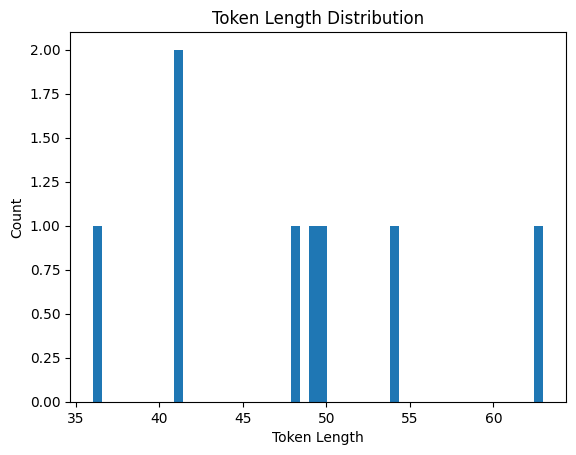

In [17]:
import matplotlib.pyplot as plt

token_lengths = finetune_df["tokens"].map_elements(len, return_dtype=pl.Int32)
print("Token length statistics:")
print(f"Mean: {token_lengths.mean()}")
print(f"Median: {token_lengths.median()}")
print(f"95th percentile: {token_lengths.quantile(0.95)}")
print(f"Max: {token_lengths.max()}")

# Plot the token length distribution
plt.hist(token_lengths, bins=50)
plt.title("Token Length Distribution")
plt.xlabel("Token Length")
plt.ylabel("Count")
plt.show()

Finally, filter to the token limit.

In [18]:
finetune_df = finetune_df.select(
    [
        pl.col("instruction"),
    ]
)

print(f"Dataset shape post-tokenization: {finetune_df.shape}")
print(finetune_df.head(1))

Dataset shape post-tokenization: (8, 1)
shape: (1, 1)
┌─────────────────────┐
│ instruction         │
│ ---                 │
│ str                 │
╞═════════════════════╡
│ <start_of_turn>user │
│ Přelož ten…         │
└─────────────────────┘


Now finally, let's calculate the dropout rate.

In [19]:
# Dropout rate is the percentage of rows that are filtered out.
dropout_rate = (len(df) - len(finetune_df)) / len(df)
print(f"Dropout rate: {dropout_rate:.2%}")

Dropout rate: 20.00%


The dropout rate is pretty high, but it's a good thing that we have a lot of data to work with and we aim for high quality results.

Now the dataset is ready for the next step. We will use it to train the model.

In [20]:
from sklearn.model_selection import train_test_split

# First split into train and temp (80/20)
train_df, temp_df = train_test_split(finetune_df, test_size=0.2, random_state=42)

# Then split temp into validation and test (50/50, resulting in 10/10 of original)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Save all splits to parquet files
train_df.write_parquet(
    file="data/processed/gemma_cs_train.parquet", compression="zstd"
)
valid_df.write_parquet(
    file="data/processed/gemma_cs_valid.parquet", compression="zstd"
)
test_df.write_parquet(
    file="data/processed/gemma_cs_test.parquet", compression="zstd"
)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")


Train size: 6
Validation size: 1
Test size: 1


# Load the model - PyTorch Lightning

In [45]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForCausalLM, AutoTokenizer
import pytorch_lightning
import logging
class GemmaLightningModule(pytorch_lightning.LightningModule):
    def __init__(self, config: TrainingConfig):
        super().__init__()
        self.config = config
        self.std_logger = logging.getLogger(__name__)

        # Load base model
        self.model = AutoModelForCausalLM.from_pretrained(
            config.model_id,
            torch_dtype=torch.bfloat16,
            device_map="auto",
        )
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_id)

        # Test prompts for monitoring
        self.test_prompts = [
            "Přelož tento text z angličtiny do češtiny:\n'I love machine learning and AI.'",
            "Přelož tento text z angličtiny do češtiny:\n'The weather is beautiful today.'",
            "Přelož tento text z angličtiny do češtiny:\n'Can you help me with directions to the train station?'",
        ]

        # Setup LoRA
        peft_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            inference_mode=False,
            r=config.lora_rank,
            lora_alpha=config.lora_alpha,
            lora_dropout=config.lora_dropout,
        )
        self.model = get_peft_model(self.model, peft_config)

    def training_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(**batch)
        loss = outputs.loss
        self.log("val_loss", loss)
        return loss

    def on_validation_epoch_end(self):
        """Generate sample translations after each validation epoch"""
        self.model.eval()
        results = []

        for prompt in self.test_prompts:
            inputs = self.tokenizer(
                prompt, 
                return_tensors="pt",
                truncation=True,
                max_length=self.config.token_limit
            ).to(self.device)

            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_new_tokens=50,
                    num_return_sequences=1,
                    temperature=0.7,
                    do_sample=True,
                    pad_token_id=self.tokenizer.pad_token_id,
                    eos_token_id=self.tokenizer.eos_token_id
                )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            results.append([prompt, generated_text])
        
        # Log the results
        for prompt, generated_text in results:
            self.std_logger.info(f"Generated text for prompt: {prompt}\n{generated_text}")

    def configure_optimizers(self):
        decay_params = []
        no_decay_params = []

        for name, param in self.named_parameters():
            if any(exclude_term in name for exclude_term in ["bias", "scale"]):
                no_decay_params.append(param)
            else:
                decay_params.append(param)

        optimizer_params = [
            {
                'params': decay_params,
                'weight_decay': 0.01
            },
            {
                'params': no_decay_params,
                'weight_decay': 0.0   # No weight decay for excluded parameters
            }
        ]
        optimizer = torch.optim.AdamW(
            optimizer_params,
            lr=self.config.learning_rate,
            eps=1e-6, # Default is 1e-8, but we need to use mixed precision training
        )
        return optimizer

# PyTorch Dataset

In [46]:
from torch.utils.data import Dataset, DataLoader


class GemmaDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]

        # Ensure we're not returning tensors with an extra dimension
        encodings = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors=None,
        )

        # Convert to tensors manually
        return {
            "input_ids": torch.tensor(
                encodings["input_ids"], dtype=torch.long
            ),
            "attention_mask": torch.tensor(
                encodings["attention_mask"], dtype=torch.long
            ),
            "labels": torch.tensor(
                encodings["input_ids"], dtype=torch.long
            ),  # Added labels for training
        }


# Import the model
model = AutoModelForCausalLM.from_pretrained(training_config.model_id)
tokenizer = AutoTokenizer.from_pretrained(training_config.model_id)

# Create datasets
train_ds = GemmaDataset(
    train_df["instruction"].to_list(), tokenizer, training_config.token_limit
)
valid_ds = GemmaDataset(
    valid_df["instruction"].to_list(), tokenizer, training_config.token_limit
)

# Create dataloaders
train_loader = DataLoader(
    train_ds,
    batch_size=training_config.batch_size,
    shuffle=True,
)
valid_loader = DataLoader(
    valid_ds,
    batch_size=training_config.batch_size,
    shuffle=False,
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Train

In [47]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, RichProgressBar
import wandb

# Setup Wandb logger
wandb_logger = pl.loggers.WandbLogger(
    project="gemma-cs",
    name=f"gemma-cs-{training_config.lora_rank}r",
    config={
        "model_name": training_config.model_id,
        "lora_rank": training_config.lora_rank,
        "batch_size": training_config.batch_size,
        "learning_rate": training_config.learning_rate,
        "epochs": training_config.epochs,
        "token_limit": training_config.token_limit,
        "accumulate_grad_batches": training_config.accumulate_grad_batches,
    },
)

# Setup callbacks
callbacks = [
    # Save best models
    ModelCheckpoint(
        dirpath=f"checkpoints/gemma-cs-{training_config.lora_rank}r",
        filename="model-{epoch:02d}-{val/loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=3,
        save_last=True,
    ),
    # Early stopping
    EarlyStopping(monitor="val_loss", patience=3, mode="min", min_delta=0.001),
    # Monitor learning rate
    LearningRateMonitor(logging_interval="step"),
    # Rich progress bar
    RichProgressBar(),
]

# Setup trainer
trainer = pl.Trainer(
    max_epochs=training_config.epochs,
    precision=training_config.precision,
    accumulate_grad_batches=training_config.accumulate_grad_batches,
    logger=wandb_logger,
    callbacks=callbacks,
    # Log gradients & model parameters
    log_every_n_steps=10,
    val_check_interval=0.25,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Create model
model = GemmaLightningModule(training_config)

# Train
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
wandb.finish()

# Save the model
model.model.save_pretrained(
    f"models/gemma-cs-{training_config.lora_rank}r-final"
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/jirka/Library/Caches/pypoetry/virtualenvs/gemma-czech-adaptation-iLYBdvQN-py3.10/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/jirka/Library/Caches/pypoetry/virtualenvs/gemma-czech-adaptation-iLYBdvQN-py3.10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/jirka/projects/competitions/gemma-global-competition/checkpoints/gemma-cs-4r exists and is not empty.


┏━━━┳━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name  ┃ Type                 ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model │ PeftModelForCausalLM │  2.5 B │ train │
└───┴───────┴──────────────────────┴────────┴───────┘

Trainable params: 460 K                                                                                            
Non-trainable params: 2.5 B                                                                                        
Total params: 2.5 B                                                                                                
Total estimated model params size (MB): 10.0 K                                                                     
Modules in train mode: 326                                                                                         
Modules in eval mode: 258

Output()

/Users/jirka/Library/Caches/pypoetry/virtualenvs/gemma-czech-adaptation-iLYBdvQN-py3.10/lib/python3.10/site-package
s/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. 
Disabling
  warnings.warn(

Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'
Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'

Tento text je v angličtině a pokládá se pod pokutu "I love". V češtině se může překreslit jako "Jám nadšán počítačová věda a AI".
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'
Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'

Pamatujte, že toto je pouze příklad a že k výpočetu počasí se používá různé metódy.
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'
Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'

**Český překlad:**

Je mi znatné vyhledat cestu k stanici trnu?


/Users/jirka/Library/Caches/pypoetry/virtualenvs/gemma-czech-adaptation-iLYBdvQN-py3.10/lib/python3.10/site-package
s/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval 
Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'
Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'

Tímto jsem uvolnil vědeckou škálu a rozvíjející se oblast, která se zabývá mocnou kombinací algoritmu a počítačové vědy.
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'
Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'

Tato řešima je však nekontextní, protože se jedná o krátký časový termín. Známos, že "beautiful" je adjektiv, který se používá k označení vlastností, které
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'
Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'

Zde je text v angličtině: "Can you help me with directions to the train station?"

**Přeložené možnosti:**

* Jistě, jsem vám může po

Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'
Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'

Tady je překlad:
"Jám můj oblíh v oblasti vývoje a AI."
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'
Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'

V češtině se to může vyjádřit jako:

* 'Sobota je krásný weer.'
* 'Má sluneční počasí dnes.'
* 'Dnes je krásný počasí.'
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'
Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'

Přečišťuji text tak, aby odpovídal specifickému zadání.


Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'
Přelož tento text z angličtiny do češtiny:
'I love machine learning and AI.'

Tímto se odkazuje na oblast technologií, která se zabývá vývojem a výpočety počítačových systémů.
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'
Přelož tento text z angličtiny do češtiny:
'The weather is beautiful today.'

Tímto jsem se pokusil přeložit toto slovo do češtiny, ale jsem se zhruba vyhrát.

**České překlady:**

* The weather is beautiful today.
* The weather is
Generated text for prompt: Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'
Přelož tento text z angličtiny do češtiny:
'Can you help me with directions to the train station?'

Tímto dokazujeme, že vám můžeme pomoci s informacemi o nádražce.

Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Load the model

In [ ]:
import keras
import keras_nlp

gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset(training_config.model_id)
gemma_lm.summary()

Let's test the inference of our prompt.

In [ ]:
prompt = 'Přelož tento text z angličtiny do češtiny:\n"Hello, world!"'
print(
    gemma_lm.generate(
        prompt,
        max_length=training_config.token_limit,
    )
)

# LoRA Fine-tuning

In [ ]:
# Enable LoRA on the model
gemma_lm.backbone.enable_lora(rank=training_config.lora_rank)
gemma_lm.summary()

# Control memory usage
gemma_lm.preprocessor.sequence_length = training_config.token_limit

# Setup optimizer
optimizer = keras.optimizers.AdamW(
    learning_rate=training_config.learning_rate,
    weight_decay=0.01,
    epsilon=1e-6, # Default is 1e-8, but we need to use mixed precision training
)

# Exclude layernorm and bias terms from decay.
optimizer.exclude_from_weight_decay(var_names=["bias", "scale"])

# Setup loss
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Setup metrics
metrics = [keras.metrics.SparseCategoricalAccuracy()]

# Compile the model
gemma_lm.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Reduce the dataset to Keras expected format


In [ ]:
train_dataset = train_df["instruction"].to_list()
valid_dataset = valid_df["instruction"].to_list()

print(f"Train dataset shape: {len(train_dataset)}")
print(train_dataset[0])
print("\n")

print(f"Valid dataset shape: {len(valid_dataset)}")
print(valid_dataset[0])

The model is now ready for training. Let's train it.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from wandb.integration.keras import WandbMetricsLogger
import wandb

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch} finished")
        model_name = f"gemma_cs_{training_config.lora_rank}_epoch{epoch+1}.lora.h5"
        gemma_lm.backbone.save_lora_weights(model_name)
        print(f"Model {model_name} saved")

        # Eval on prompt
        prompt = "Přelož tento text z angličtiny do češtiny.\n\"Hello, world!\""
        print(f"Prompt: {prompt}")
        print(
            f"Response: {gemma_lm.generate(prompt, max_length=training_config.token_limit)}"
        )

# Initialize a new W&B run
wandb.init(config={
    "learning_rate": training_config.learning_rate,
    "epochs": training_config.epochs,
    "batch_size": training_config.batch_size,
    "lora_rank": training_config.lora_rank,
    "token_limit": training_config.token_limit,
    "model": "gemma2_instruct_2b_en",
    "task": "czech-context"
})

# Convert lists to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices(train_dataset)
valid_ds = tf.data.Dataset.from_tensor_slices(valid_dataset)

# Configure datasets for performance
train_ds = train_ds.batch(training_config.batch_size)
valid_ds = valid_ds.batch(training_config.batch_size)

# Enable prefetching to improve performance
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

# Train the model
history = gemma_lm.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=training_config.epochs,
    callbacks=[CustomCallback(), WandbMetricsLogger()],
)

# Plot the training loss
plt.plot(history.history["loss"])
plt.show()

# Plot the accuracy
plt.plot(history.history["sparse_categorical_accuracy"])
plt.show()